In [1]:
import torch
import pandas as pd
import json
# from torch.utils.data import DataLoader, SequentialSampler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain
from tqdm.auto import tqdm
from pathlib import Path

from dataset import TwitterDataset
from autoencoders import load_encoder

dset = TwitterDataset(
    'timestamp',
    spam_idx_path="spam_idx.pkl",
    sentiment_path='sentiment/vader/',
    # whole_text_path = 'whole_text',
    # token_path = 'tokens/text',
    embedding_path = 'embeddings/all-MiniLM-L6-v2/',
)

loading from timestamp:   0%|          | 0/221 [00:00<?, ?it/s]

loading sentiment..:   0%|          | 0/221 [00:00<?, ?it/s]

loading embeddings..:   0%|          | 0/221 [00:00<?, ?it/s]

no spam here!
loaded dataset. took 161.7367698289454 ms. Got 18932577 items


In [2]:
model = load_encoder('models/LinearAutoEncoder.pkl','linear')
for p in model.parameters():
    p.requires_grad = False

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
import time

size = 1000000
model = model.cuda()

#find elbow using inertia and distortion
#use minibatch for optimal k computation to speed up calculations
cluster_count = range(2, 20)
batched_elbows = [0]*len(cluster_count)
km_multiple = [MiniBatchKMeans(n_clusters=i, max_iter=100) for i in cluster_count]

In [8]:
it_count = 0
for i in range(len(dset.embedding)):
  it_count+=1
  start = time.perf_counter()
  
  inp = dset.embedding[i*size: (i+1)*size].cuda()
  out = model.encoder(inp).cpu().numpy()
  if len(out) == 0:
    break
  
  fits = [i.fit(out) for i in km_multiple]
  inertias = [i.inertia_ for i in fits]
  #s_start = time.perf_counter()
  #s_scores = [silhouette_score(out, i.labels_) for i in fits]
  #sillhouettes = [a+b for a,b in zip(s_scores, sillhouettes)]
  #s_time = time.perf_counter()-start
  #print(s_time)
  batched_elbows = [a+b for a, b in zip(inertias, batched_elbows)]
  del out

  print("Iteration", it_count, f"Time taken:  {time.perf_counter()-start} seconds")
  #break
  #jsquared errors for evaluating internal consistency in clusters

Iteration 1 Time taken:  50.556731935590506 seconds
Iteration 2 Time taken:  33.87366230040789 seconds
Iteration 3 Time taken:  44.505744667723775 seconds
Iteration 4 Time taken:  34.44819572009146 seconds
Iteration 5 Time taken:  44.60995979234576 seconds
Iteration 6 Time taken:  49.184482956305146 seconds
Iteration 7 Time taken:  30.255304971709847 seconds
Iteration 8 Time taken:  41.94792958162725 seconds
Iteration 9 Time taken:  44.86602708697319 seconds
Iteration 10 Time taken:  40.47576590999961 seconds
Iteration 11 Time taken:  45.905420096591115 seconds
Iteration 12 Time taken:  33.850564578548074 seconds
Iteration 13 Time taken:  38.777586402371526 seconds
Iteration 14 Time taken:  43.27764131128788 seconds
Iteration 15 Time taken:  43.5285266675055 seconds
Iteration 16 Time taken:  35.29929781705141 seconds
Iteration 17 Time taken:  44.12242528796196 seconds
Iteration 18 Time taken:  41.463864924386144 seconds
Iteration 19 Time taken:  40.778621627017856 seconds
Iteration 20 

In [9]:
from kneed import KneeLocator
knee_loc = KneeLocator(range(2, 20), batched_elbows, curve="convex", direction="decreasing")
knee_loc.elbow

7

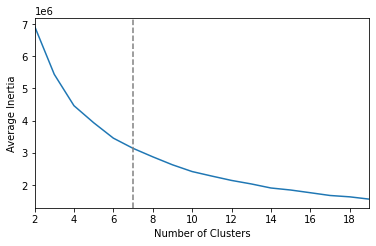

In [16]:
import matplotlib.pyplot as plt

results = [x/it_count for x in batched_elbows]
plt.figure(figsize=(6, 3.5))
plt.plot(cluster_count, results)
plt.xlim(2, 19)
#plt.title("Elbow Plot for Optimal K Discovery")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Inertia")
plt.axvline(x=knee_loc.elbow, color="grey", linestyle='--')
#plt.show()

plt.savefig('kmeans_elbow.pdf')

In [ ]:
from sklearn.cluster import DBSCAN

batched_dbelbows = [0]*len(cluster_count)
db_multiple = [DBSCAN(n_clusters=i, max_iter=100) for i in cluster_count]